Multiple linear regression analysis is a statistical technique used to model the relationship between two or more independent variables ($x$) and a single dependent variable ($y$). By fitting a linear equation to observed data, this method allows for the prediction of the dependent variable based on the values of the independent variables. It extends simple linear regression, which involves only one independent variable, to include multiple factors, providing a more comprehensive understanding of complex relationships within the data. The general formula is:
$$ y = \beta_0 \ + \beta_1 \ x_1 + ... + \beta_n \ x_n$$

An agronomic example that involves the use of multiple linear regression are allometric measurements, such as estimating corn biomass based on plant height and stem diameter.

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
# Read dataset
df = pd.read_csv("../datasets/corn_allometric_biomass.csv")
df.head(3)


,height_cm,stem_diam_mm,dry_biomass_g
0,71.0,5.7,0.66
1,39.0,4.4,0.19
2,55.5,4.3,0.30


In [3]:
# Re-define variables for better plot semantics and shorter variable names
xdata = df['stem_diam_mm'].values
ydata = df['height_cm'].values
zdata = df['dry_biomass_g'].values


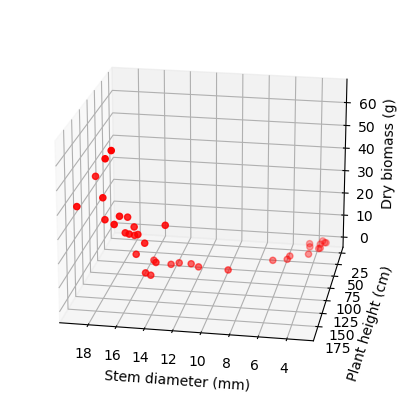

In [4]:
# Plot raw data using 3D plots.
# Great tutorial: https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
#ax = fig.add_subplot(projection='3d')


# Define axess
ax.scatter3D(xdata, ydata, zdata, c='r');
ax.set_xlabel('Stem diameter (mm)') 
ax.set_ylabel('Plant height (cm)')
ax.set_zlabel('Dry biomass (g)')

ax.view_init(elev=20, azim=100)
plt.show()

# elev=None, azim=None
# elev = elevation angle in the z plane.
# azim = stores the azimuth angle in the x,y plane.


In [5]:
# Full model (you can also use xdata and ydata)
X = np.column_stack((np.ones(df.shape[0]), # We can also use X = sm.add_constant(X)
                     df['height_cm'],
                     df['stem_diam_mm'],
                     df['height_cm'] * df['stem_diam_mm']))  # interaction term

# Print a few rows
print(X[0:3,:])

[[  1.    71.     5.7  404.7 ]
 [  1.    39.     4.4  171.6 ]
 [  1.    55.5    4.3  238.65]]


In [6]:
# Run Ordinary Least Squares to fit the model
model = sm.OLS(df['dry_biomass_g'], X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:          dry_biomass_g   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     63.71
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           4.87e-14
Time:                        11:33:44   Log-Likelihood:                -129.26
No. Observations:                  38   AIC:                             266.5
Df Residuals:                      34   BIC:                             273.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8097      6.022      3.124      0.0

`height` (x1) does not seem to be statistically significant. This term has a p-value > 0.05 and the range of the 95% confidence interval for its corresponding $\beta$ coefficient includes zero. 

The goal is to prune the full model by removing non-significant terms. After removing these terms, we need to fit the model again to update the new coefficients.

In [7]:
# Define prunned model
X_prunned = np.column_stack((np.ones(df.shape[0]), 
                     df['stem_diam_mm'], 
                     df['height_cm'] * df['stem_diam_mm']))

# Re-fit the model
model_prunned = sm.OLS(df['dry_biomass_g'], X_prunned)
results_prunned = model_prunned.fit()
print(results_prunned.summary())


                            OLS Regression Results                            
Dep. Variable:          dry_biomass_g   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     90.81
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           1.40e-14
Time:                        11:33:46   Log-Likelihood:                -130.54
No. Observations:                  38   AIC:                             267.1
Df Residuals:                      35   BIC:                             272.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0338      5.263      2.666      0.0

The prunned model has:
- r-squared remains similar
- one less parameter
- higher F-Statistic 91 vs 63
- AIC remains similar (the lower the better)

In [8]:
# Access parameter/coefficient values
print(results_prunned.params)


const    14.033781
x1       -5.092159
x2        0.036719
dtype: float64


In [9]:
# Create surface grid

# Xgrid is grid of stem diameter
x = np.linspace(xdata.min(), xdata.max(), 21)

# Ygrid is grid of plant height
y = np.linspace(ydata.min(), ydata.max(), 21)

# We generate a 2D grid
X_grid, Y_grid = np.meshgrid(x, y)

# Create intercept grid
intercept = np.ones(X_grid.shape)

# Get parameter values
pars = results_prunned.params.values

# Z is the elevation of this 2D grid
Z_grid = intercept*pars[0] + X_grid*pars[1] + X_grid*Y_grid*pars[2]


Alternatively you can use the `.predict()` method of the fitted object. This option would required flattening the arrays to make predictions:

```
X_pred = np.column_stack((intercept.flatten(), X_grid.flatten(), X_grid.flatten() * Y_grid.flatten()) )
Z_grid = model_prunned.predict(params=results_prunned.params, exog=X_pred)
Z_grid = np.reshape(Z_grid, X_grid.shape) # Reset shape to match 
```

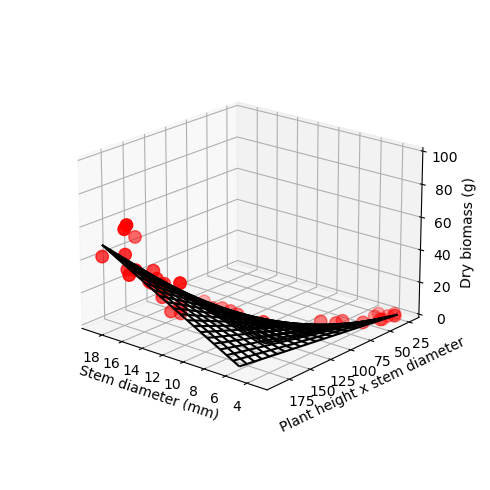

In [10]:
# Plot points with predicted model (which is a surface)

# Create figure and axes
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, c='r', s=80);
surf = ax.plot_wireframe(X_grid, Y_grid, Z_grid, color='black')
#surf = ax.plot_surface(Xgrid, Ygrid, Zgrid, cmap=plt.cm.coolwarm,rstride=1, cstride=1)
ax.set_xlabel('Stem diameter (mm)')
ax.set_ylabel('Plant height x stem diameter')
ax.set_zlabel('Dry biomass (g)')
ax.view_init(20, 130)
fig.tight_layout()
ax.set_box_aspect(aspect=None, zoom=0.8) # Zoom out to see zlabel
ax.set_zlim([0,100])
plt.show()



In [11]:
# We can now create a lambda function to help use convert other observations
corn_biomass_fn = lambda stem,height: pars[0] + stem*pars[1] + stem*height*pars[2]

In [12]:
# Test the lambda function using stem = 11 mm and height = 120 cm
biomass = corn_biomass_fn(11, 120)
print(round(biomass,2), 'g')


6.49 g
